<a href="https://colab.research.google.com/github/makhti/-selfeducation/blob/master/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Copy_of_%D0%A0%D0%B0%D0%B7%D0%B1%D0%BE%D1%80_%D0%94%D0%97_%D0%90%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%B8_ipynb%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# #
Напишите “автокодировщик”, который будет из рукописных цифр MNIST генерировать из соответствующего изображения на CIFAR или Fashion Mnist, т.е. генерируйте из цифры MNIST - картинки CIFAR соответствующего класса

Сделайте такую же генерацию Fashion Mnist


*Fashion Mnist успешно генерируется, а Cifar10 нет, на проверочной выборке получаются цветные образы, но не чистые изображения


**это не совсем автокодировщик, так как у автокодировщика вход строго равен выходу, но архитектура очень близкая к автокодировщику


In [ ]:
from tensorflow.keras.models import Model, Sequential # загружаем абстрактный класс базовой модели сети от кераса и последовательную модель
# Из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D
from tensorflow.keras import backend as K # подтягиваем базовые керасовские функции
from tensorflow.keras.optimizers import Adam # загружаем выбранный оптимизатор
from tensorflow.keras import utils # загружаем утилиты кераса
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10 # загружаем готовые базы mnist

import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
from tensorflow.keras.preprocessing import image # модуль для отрисовки изображения
import numpy as np # библиотека для работы с массивами данных
import pandas as pd # библиотека для анализа и обработки данных
from PIL import Image # модуль для отрисовки изображения
from sklearn.model_selection import train_test_split # модуль для разбивки выборки на тренировочную/тестовую
from sklearn.preprocessing import StandardScaler # модуль для стандартизации данных

import os #
from google.colab import drive #модуль для работы с google диском 
import time

## Функции

In [ ]:
def plotImages(xTrain, pred, shape=(112, 80)): # создадим функцию для вывода изображений как картинок
  n = 5  # количество картинок, которые хотим показать
  plt.figure(figsize=(10, 4)) # указываем размеры фигуры
  for i in range(n): # для каждой картинки из n(5)
      index = np.random.randint(0, pred.shape[0]) # startIndex - начиная с какого индекса хотим заплотить картинки
      # Показываем картинки из тестового набора
      ax = plt.subplot(2, n, i + 1) # выведем область рисования Axes
      plt.imshow(xTrain[index].reshape(shape)) # отрисуем правильные картинки в размере 112*80      
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

      # Показываем восстановленные картинки
      ax = plt.subplot(2, n, i + 1 + n) # выведем область рисования Axes 
      plt.imshow(pred[index].reshape(shape)) # отрисуем обработанные сеткой картинки в размере 112*80     
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
  plt.show()

In [ ]:
def getMSE(x1, x2): # создадим функцию среднеквадратичной ошибки
  x1 = x1.flatten() # сплющиваем в одномерный вектор
  x2 = x2.flatten() # сплющиваем в одномерный вектор
  delta = x1 - x2 # находим разницу
  return sum(delta ** 2) / len(delta) # и возвращаем сумму квадратов разницы, делённую на длину разницы

In [ ]:
# функция загрузки изображений, на вход принемает имя папки с изображениями, высоту и ширину к которой будут преобразованы загружаемые изображения
def load_images(images_dir, img_height, img_width): 
  list_images = [] # создаем пустой список в который будем загружать изображения
  for img in os.listdir(images_dir): # получим список изображений и для каждого изображения
  # добавим в список изображение в виде массива, с заданными размерами, в отенках серого
    list_images.append(image.img_to_array(image.load_img(os.path.join(images_dir, img), target_size=(img_height, img_width), color_mode='grayscale')))
  return np.array(list_images) # возвращаем numpy массив загруженных избражений

In [ ]:
def plotImages_(startIndex, xTrain, pred, size=(28,28,)):
  n = 5  # Количество картинок, которые хотим показать
  plt.figure(figsize=(10, 4))
  for i in range(n):
      index = i + startIndex
      # Показываем картинки из тестового набора
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(xTrain[index].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Показываем восстановленные картинки
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(pred[index].reshape(size))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()

In [ ]:
def baseAutoencoder(shape=(112,80,1)): # зададим функцию создания базового автокодировщика
    img_input = Input((shape)) # задаём входные размеры

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) # входные данные передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # затем пропускаем через слой нормализации данных 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # далее снова слой двумерной свёртки
    x = BatchNormalization()(x) # и еще слой нормализации данных
    x = MaxPooling2D()(x) # передаём на слой подвыборки, снижающий размерность поступивших на него данных

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # пропускаем через слой нормализации данных 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)  # далее снова слой двумерной свёртки
    x = BatchNormalization()(x) # и еще слой нормализации данных
    z = MaxPooling2D()(x) # передаём на слой подвыборки
    

    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z) # слой разжимает данные(с 28*20 на 56*40)
    x = BatchNormalization()(x) # слой нормализации данных
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных

    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) # слой разжимает данные(с 56*40 на 112*80)
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных

    # Финальный слой двумерной свертки, выдающий итоговое изображение
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) # указываем модель, с оригинальным изображением на входе в сеть и сжатым-разжатым на выходе из сети
    model.compile(optimizer=Adam(lr=0.0001),
                  loss='mean_squared_error') # компилируем модель с оптимайзером Адам и среднеквадратичной ошибкой

    return model # функция вернёт заданную модель

In [ ]:
def baseAutoencoder_cifar(shape=(28,28,1)): # зададим функцию создания базового автокодировщика
    img_input = Input((shape)) # задаём входные размеры

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) # входные данные передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # затем пропускаем через слой нормализации данных 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # далее снова слой двумерной свёртки
    x = BatchNormalization()(x) # и еще слой нормализации данных
    x = MaxPooling2D()(x) # передаём на слой подвыборки, снижающий размерность поступивших на него данных

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # пропускаем через слой нормализации данных 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)  # далее снова слой двумерной свёртки
    x = BatchNormalization()(x) # и еще слой нормализации данных
    z = MaxPooling2D()(x) # передаём на слой подвыборки

    z = Flatten()(z)
    z = Dense(8*8*64, activation='linear')(z) # Меням размер для cifar10
    x = Reshape((8,8,64))(z)


    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) # слой разжимает данные(с 8*8 на 16*16)
    x = BatchNormalization()(x) # слой нормализации данных
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных

    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) # слой разжимает данные(с 16*16 на 32*32)
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных

    # Финальный слой двумерной свертки, выдающий итоговое изображение
    x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # 3 канала

    model = Model(img_input, x) # указываем модель, с оригинальным изображением на входе в сеть и сжатым-разжатым на выходе из сети
    model.compile(optimizer=Adam(lr=0.0001),
                  loss='mean_squared_error') # компилируем модель с оптимайзером Адам и среднеквадратичной ошибкой

    return model # функция вернёт заданную модель

## Выборки

In [ ]:
(x_train_m, y_train_m), (x_test_m, y_test_m) = mnist.load_data()
(x_train_f, y_train_f), (x_test_f, y_test_f) = fashion_mnist.load_data()
(x_train_c10, y_train_c10), (x_test_c10, y_test_c10) = cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [ ]:
def creat_data(x_m, x_f, x_c10, y_m, y_f, y_c, size=1000):
    x_m_   = []
    x_f_   = []
    x_c10_ = []

    for i in range(y_m.max()+1):
        x_m_.extend(x_m[y_m == i][:size])
        x_f_.extend(x_f[y_f == i][:size])
        x_c10_.extend(x_c10[np.array([y_c == i]).reshape(x_c10.shape[0],)][:size])

    x_m_arr   = np.array(x_m_)
    x_f_arr   = np.array(x_f_)
    x_c10_arr = np.array(x_c10_)
    return x_m_arr[...,None]/255, x_f_arr[...,None]/255, x_c10_arr/255

x_m_arr, x_f_arr, x_c10_arr = creat_data(x_train_m, x_train_f, x_train_c10, y_train_m, y_train_f, y_train_c10)
x_m_arr_test, x_f_arr_test, x_c10_arr_test = creat_data(x_test_m, x_test_f, x_test_c10, y_test_m, y_test_f, y_test_c10, size=300)

x_c10_arr.shape, x_f_arr.shape, x_m_arr.shape, x_m_arr_test.shape, x_f_arr_test.shape, x_c10_arr_test.shape

((10000, 32, 32, 3),
 (10000, 28, 28, 1),
 (10000, 28, 28, 1),
 (3000, 28, 28, 1),
 (3000, 28, 28, 1),
 (3000, 32, 32, 3))

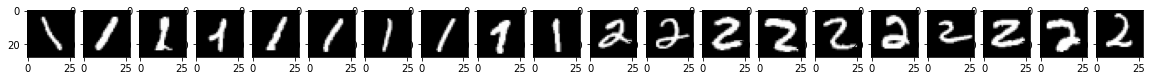

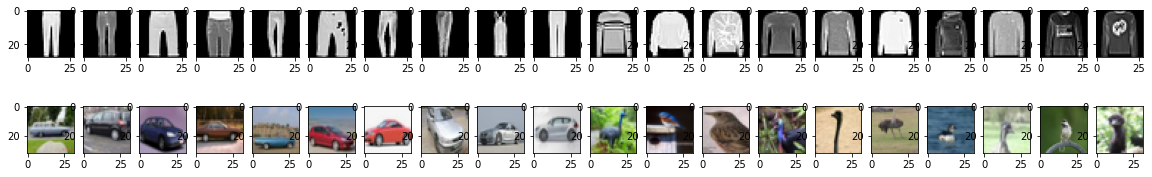

In [ ]:
# Убедимся, что классы соответствуют друг другу

plt.figure(figsize=(20,5))
for i in range(20):
    plt.subplot(3, 20, i + 1)
    plt.imshow(x_m_arr[i+1990].reshape(28,28))
plt.figure(figsize=(20,5))

for i in range(20):
    plt.subplot(3, 20, i + 21)
    plt.imshow(x_f_arr[i+1990].reshape(28,28))

for i in range(20):
    plt.subplot(3, 20, i + 41)
    plt.imshow(x_c10_arr[i+1990].reshape(32,32,3))
plt.show()

In [ ]:
model_M_F = baseAutoencoder((28,28,1)) # создаем автокодировщик
model_M_F.fit(x_m_arr, x_f_arr, 
              epochs=50, 
              batch_size=256, 
              validation_data = (x_m_arr_test, x_f_arr_test),
              shuffle=True)

Epoch 1/50
40/40 [==============================] - 1s 23ms/step - loss: 0.1677 - val_loss: 0.1389
Epoch 2/50
40/40 [==============================] - 1s 17ms/step - loss: 0.1268 - val_loss: 0.1305
Epoch 3/50
40/40 [==============================] - 1s 17ms/step - loss: 0.1114 - val_loss: 0.1383
Epoch 4/50
40/40 [==============================] - 1s 17ms/step - loss: 0.1022 - val_loss: 0.1516
Epoch 5/50
40/40 [==============================] - 1s 17ms/step - loss: 0.0958 - val_loss: 0.1619
Epoch 6/50
40/40 [==============================] - 1s 17ms/step - loss: 0.0910 - val_loss: 0.1653
Epoch 7/50
40/40 [==============================] - 1s 18ms/step - loss: 0.0871 - val_loss: 0.1582
Epoch 8/50
40/40 [==============================] - 1s 17ms/step - loss: 0.0841 - val_loss: 0.1339
Epoch 9/50
40/40 [==============================] - 1s 17ms/step - loss: 0.0815 - val_loss: 0.1199
Epoch 10/50
40/40 [==============================] - 1s 17ms/step - loss: 0.0794 - val_loss: 0.1102
Epoch 11/

In [ ]:
model_M_C = baseAutoencoder_cifar((28,28,1)) # создаем автокодировщик
model_M_C.fit(x_m_arr, x_c10_arr, 
              epochs=50, 
              batch_size=256, 
              validation_data = (x_m_arr_test, x_c10_arr_test),
              shuffle=True)

Epoch 1/50
40/40 [==============================] - 1s 30ms/step - loss: 0.0928 - val_loss: 0.0631
Epoch 2/50
40/40 [==============================] - 1s 23ms/step - loss: 0.0667 - val_loss: 0.0632
Epoch 3/50
40/40 [==============================] - 1s 22ms/step - loss: 0.0629 - val_loss: 0.0634
Epoch 4/50
40/40 [==============================] - 1s 22ms/step - loss: 0.0615 - val_loss: 0.0638
Epoch 5/50
40/40 [==============================] - 1s 22ms/step - loss: 0.0604 - val_loss: 0.0645
Epoch 6/50
40/40 [==============================] - 1s 22ms/step - loss: 0.0598 - val_loss: 0.0645
Epoch 7/50
40/40 [==============================] - 1s 22ms/step - loss: 0.0592 - val_loss: 0.0641
Epoch 8/50
40/40 [==============================] - 1s 23ms/step - loss: 0.0587 - val_loss: 0.0639
Epoch 9/50
40/40 [==============================] - 1s 22ms/step - loss: 0.0579 - val_loss: 0.0626
Epoch 10/50
40/40 [==============================] - 1s 22ms/step - loss: 0.0574 - val_loss: 0.0640
Epoch 11/

In [ ]:
pred_f = model_M_F.predict(x_m_arr_test)
pred_c = model_M_C.predict(x_m_arr_test)

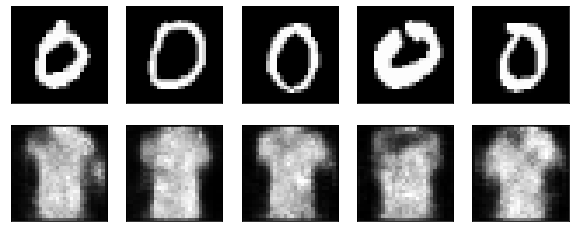

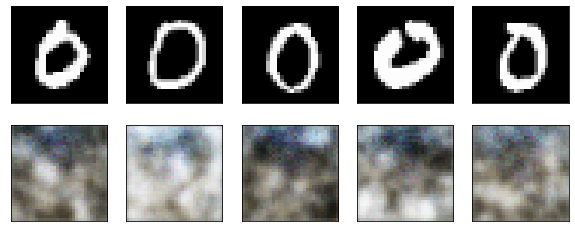

In [ ]:
plotImages_(0, x_m_arr_test, pred_f)
plotImages_(0, x_m_arr_test, pred_c, size=(32,32,3))

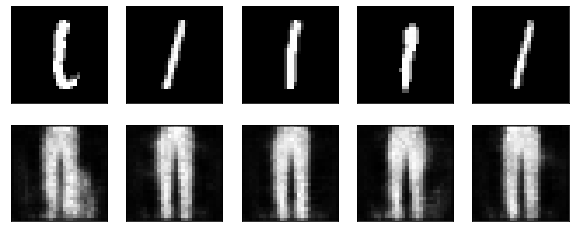

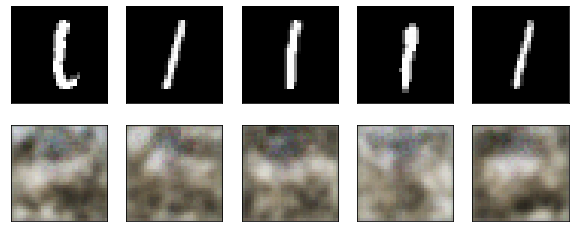

In [ ]:
plotImages_(400, x_m_arr_test, pred_f)
plotImages_(400, x_m_arr_test, pred_c, size=(32,32,3))